In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Iat is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from PIL import Image
import os

In [ ]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work

print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])


print ('Available devices ', torch.cuda.device_count())



__Python VERSION: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
__pyTorch VERSION: 1.8.1+cu101
__CUDA VERSION
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Available devices  1


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.optim import SGD

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driveFiles = GoogleDrive(gauth)

In [ ]:
#GENERATION DE L ACCES AU DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_transforms_train = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transforms_valid = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transforms_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
#Load the datasets with ImageFolder
datadir='/content/drive/MyDrive/computer-vision/'
train_dir=datadir + 'Data_train'
valid_dir=datadir + 'Data_valid'
test_dir=datadir + 'Data_test'
image_dataset_train = datasets.ImageFolder(train_dir, transform = data_transforms_train)
image_dataset_valid = datasets.ImageFolder(valid_dir, transform = data_transforms_valid)
image_dataset_test = datasets.ImageFolder(test_dir, transform = data_transforms_test)

In [ ]:
# Using the image datasets and the trainforms, define the dataloaders
#batch size and num workers can be modified accordingly. 
batch_size =128
num_workers=2
 

dataloader_train = torch.utils.data.DataLoader(image_dataset_train, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(image_dataset_valid, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)

dataloader_test = torch.utils.data.DataLoader(image_dataset_test, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)

In [ ]:
#Define classnames
class_names = image_dataset_train.classes

In [ ]:
class_names

['a', 'c', 'd', 'g', 'h', 'm', 'n', 'o']

In [ ]:
starts=class_names
label=[1,2,3,4,5,6,7,8]
dict_=dict(zip(starts,label))

In [ ]:
#Load DenseNet201 
model= models.densenet201(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


In [ ]:
#Freeze denseblock layers for retraining, Optional
for name, child in model.features.named_children():
    if name in ['conv0', 'norm0','relu0','pool0','denseblock1','transition1','denseblock2','transition2','transition3','norm5']:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

    else:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True

conv0 is frozen
norm0 is frozen
relu0 is frozen
pool0 is frozen
denseblock1 is frozen
transition1 is frozen
denseblock2 is frozen
transition2 is frozen
denseblock3 is unfrozen
transition3 is frozen
denseblock4 is unfrozen
norm5 is frozen


In [ ]:
# * Define a new, untrained feed-forward network as a classifier
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class ClassifierH2(nn.Module):
    def __init__(self, inp = 1920, h1=1024, output = 8, drop=0.5):
        super().__init__()
        self.adaptivePool = nn.AdaptiveAvgPool2d((1,1))
        self.maxPool = nn.AdaptiveMaxPool2d((1,1))
        
        self.fla = Flatten()
        self.batchN0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(drop)
        self.fc1 = nn.Linear(inp*2, h1)
        self.batchN1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(drop)

        self.fc3 = nn.Linear(h1, output)
        
    def forward(self, x):
        adaptivePool = self.adaptivePool(x)
        maxPool = self.maxPool(x)
        x = torch.cat((adaptivePool,maxPool),dim=1)
        x = self.fla(x)
        x = self.batchN0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.batchN1(x)
        x = self.dropout1(x)         
        x = self.fc3(x)
        
        return x


In [ ]:
#Set Model
model = nn.Sequential(*list(model.children())[:-1],ClassifierH2(),nn.LogSoftmax(dim=1))


In [ ]:
#Train on multiple GPUs if available, else train on cpu
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Mon May 24 08:25:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |  15257MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model.to(device)

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): R

In [ ]:
#Define optmizer and scheduler
# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
#Note,  model.module.parameters() is referencing the DataParallel module. If model is trained on CPU or individual GPU will need to be modifed Accordingly. 

#according to how model was trained. 
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Define scheduler to decrease learning rate with increase in epochs
sched = lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.1)


In [ ]:
#Train and Evaluate the model
#Training
#Track the loss and accuracy on the validation set to determine the best hyperparameters

# number of epochs to train the model
n_epochs = 50
import time
since = time.time()

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # track change in validation loss


train_losses, valid_losses = [], []
for epoch in range(n_epochs):
    ###################
    # train the model #
    ###################

    sched.step()
    model.train()
    train_loss = 0.0
    
    print("Starting Training")
    for data, target in dataloader_train:
        # move tensors to GPU
        data, target = data.to(device,  dtype=torch.float), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        train_loss += loss.item()
        
    else:
        valid_loss = 0.0
        accuracy = 0
        
        ######################    
        # validate the model #
        ######################
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
        
        print("Starting Validation")
        model.eval()
        with torch.no_grad():
            for data, target in dataloader_valid:
                # move tensors to GPU
                data, target = data.to(device), target.to(device)
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # update average validation loss 
                valid_loss += criterion(output, target)
                
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == target.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(dataloader_train))
        valid_losses.append(valid_loss/len(dataloader_valid))
        
        
        print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(dataloader_train)),
              "Validation Loss: {:.3f}.. ".format(valid_loss/len(dataloader_valid)),
              "Test Accuracy: {:.3f}".format(accuracy/len(dataloader_valid)))
        
        time_elapsed_total = time.time() - since
        print('Training plus Validation complete in {:.0f}m {:.0f}s'.format(
        time_elapsed_total // 60, time_elapsed_total % 60))

        # Average validation loss
        valid_loss = valid_loss / len(dataloader_valid)

        # If the validation loss is at a minimum
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            # Save the model
            #Note, state_dict is saved as model.module.state_dict() as this model was trained using DataParallel. Will need to be modified
            #according to how model was setup. 
            torch.save({
                        'epoch': epoch,                            
                        'state_dict':model.state_dict(),
                        'optimizer_state_dict':optimizer.state_dict(),
                        'loss': valid_loss,
                        'class_mapping': image_dataset_train.class_to_idx
                        },'/content/drive/MyDrive/computer-vision/model_D201_v1.pth')
                                  
            valid_loss_min = valid_loss

Starting Training
Training complete in 14m 58s
Starting Validation
Epoch: 1/50..  Training Loss: 0.916..  Validation Loss: 121.098..  Test Accuracy: 0.335
Training plus Validation complete in 17m 52s
Validation loss decreased (inf --> 121.097786).  Saving model ...
Starting Training
Training complete in 18m 38s
Starting Validation
Epoch: 2/50..  Training Loss: 0.717..  Validation Loss: 58.228..  Test Accuracy: 0.601
Training plus Validation complete in 18m 40s
Validation loss decreased (121.097786 --> 58.228336).  Saving model ...
Starting Training
Training complete in 19m 25s
Starting Validation
Epoch: 3/50..  Training Loss: 0.599..  Validation Loss: 0.592..  Test Accuracy: 0.731
Training plus Validation complete in 19m 27s
Validation loss decreased (58.228336 --> 0.592272).  Saving model ...
Starting Training
Training complete in 20m 13s
Starting Validation
Epoch: 4/50..  Training Loss: 0.602..  Validation Loss: 0.649..  Test Accuracy: 0.743
Training plus Validation complete in 20m 1

In [ ]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_path):
    
    checkpoint = torch.load(checkpoint_path)
    
    model = models.densenet201(pretrained=True)
   
    for param in model.parameters():
        param.requires_grad = False
     
    # Put the classifier on the pretrained network
    classifier = ClassifierH2()
    
    model = nn.Sequential(*list(model.children())[:-1], classifier, nn.LogSoftmax(dim=1))
    
    #Load the state dic
    model.load_state_dict(checkpoint['state_dict'],strict = False)
    
    #Load the Class Maps
    model.class_to_idx = checkpoint['class_mapping']
     
    return model

In [ ]:
checkpoint_path = '/content/drive/MyDrive/computer-vision/model_D201_v1.pth'
model = load_checkpoint(checkpoint_path)

In [ ]:
#To load optimizer state
checkpoint = torch.load('/content/drive/MyDrive/computer-vision/model_D201_v1.pth')
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
#Function to test model accuracy against test data. 
def calc_accuracy(model, dataloader_,cuda=False):
    model.eval()
    model.to(device='cuda')    
    total_acc =0
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader_):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            print
            # max provides the (maximum probability, max value)
            total_acc += accuracy(outputs, labels)
        n_entries=len(dataloader_)
        acc=(total_acc/n_entries).item()
    return acc
            


In [ ]:
def accuracy(output, target):
    return (torch.argmax(output, dim=1) == target).float().mean()

In [ ]:
calc_accuracy(model,dataloader_test, True)

0.5074372291564941

In [ ]:
calc_accuracy(model,dataloader_train, True)

0.9793540239334106

In [ ]:
calc_accuracy(model,dataloader_valid, True)

0.8957812786102295

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


In [ ]:
@torch.no_grad()
def get_all_prediction(model, loader):
    model.to('cuda')
    preds = torch.tensor([]).cuda()
    trues=torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        batch_predictions = model(images)
        preds = torch.cat((preds, batch_predictions), dim = 0)
        trues = torch.cat((trues, labels), dim = 0)
    return preds,trues

In [ ]:
predictions_test,trues_test = get_all_prediction(model, dataloader_test)
predictions_train,trues_train = get_all_prediction(model, dataloader_train)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:

ypred=torch.argmax(predictions_train, dim=1)

Confusion matrix, without normalization
[[932   0   0   0   0   0   0   0]
 [  0 932   0   0   0   0   0   0]
 [  0   0 838   0   0   0  93   0]
 [  0   0   0 932   0   0   0   0]
 [  0   0   0   0 957   0   0   0]
 [  0   0   0   0   0 947   0   0]
 [  0   0  61   0   0   0 885   0]
 [  0   1   0   0   0   0   0 944]]


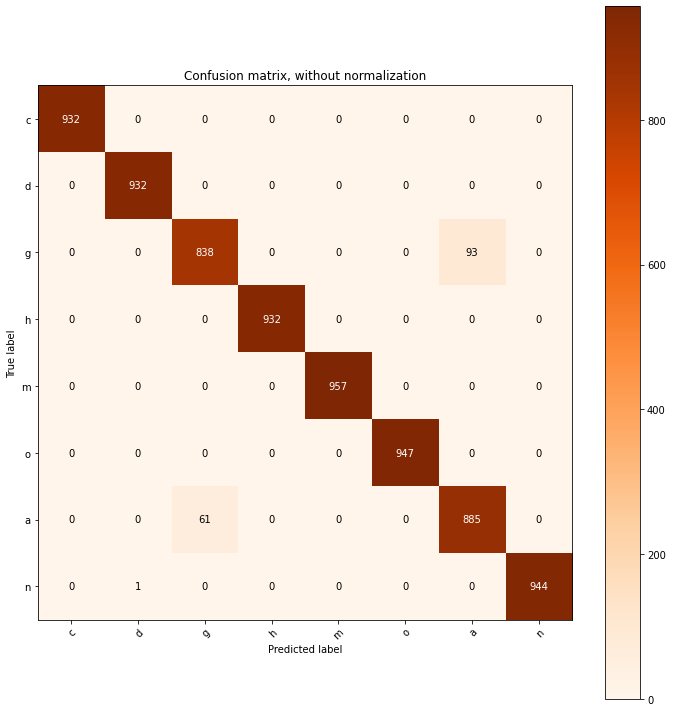

In [ ]:

label_dict={'a', 'c', 'd', 'g', 'h', 'm', 'n', 'o'}
plot_confusion_matrix(trues_train, ypred, classes=label_dict)

Confusion matrix, without normalization
[[  3   0  36   0   0   0   7   0]
 [  0  11   1   0   0   0  46   0]
 [  0   0 239   0   0   0  94   0]
 [  0   0  14   0   0   0  47   0]
 [  0   0  22   0   0   0   6   0]
 [  0   0  12   0   0  13  23   0]
 [  0   0 186   0   0   0 383   0]
 [  1   0  86   0   0   0  49   0]]


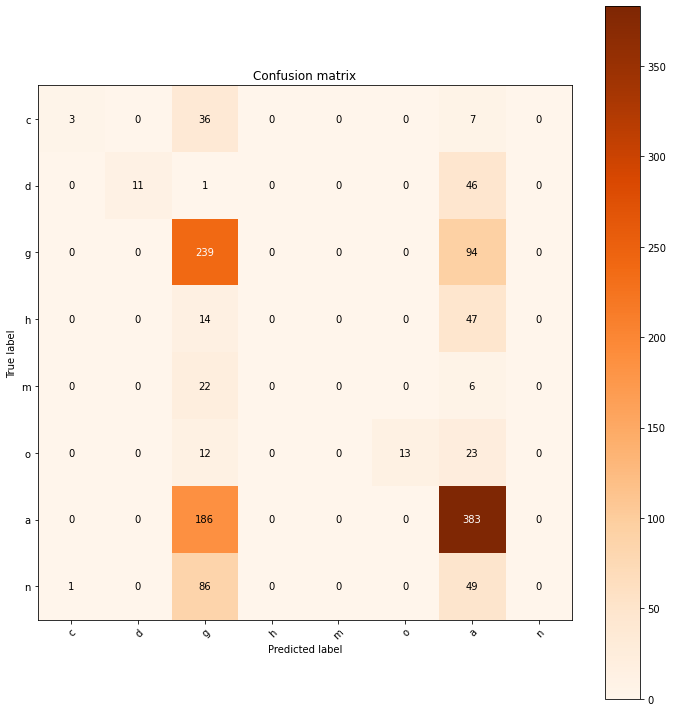

In [ ]:
ypredtest=torch.argmax(predictions_test, dim=1)
plot_confusion_matrix(trues_test, ypredtest, classes=label_dict,
                      title='Confusion matrix')

In [ ]:

from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, recall_score, f1_score
def offline_metrics(trues_test,ypredtest):
  trues_test, ypredtest = trues_test.cpu(), ypredtest.cpu()
  accuracytest = accuracy_score(trues_test, ypredtest)
  balancedaccuracytest = balanced_accuracy_score(trues_test, ypredtest)
  microprecisiontest = precision_score(trues_test, ypredtest, average = 'micro')
  macroprecisiontest = precision_score(trues_test, ypredtest, average = 'macro')
  weightedprecisiontest = precision_score(trues_test, ypredtest, average = 'weighted')

  microrecalltest = recall_score(trues_test, ypredtest, average = 'micro')
  macrorecalltest = recall_score(trues_test, ypredtest, average = 'macro')
  weightedrecalltest = recall_score(trues_test, ypredtest, average = 'weighted')

  microf1test = f1_score(trues_test, ypredtest, average = 'micro')
  macrof1test = f1_score(trues_test, ypredtest, average = 'macro')
  weightedf1test = f1_score(trues_test, ypredtest, average = 'weighted')

  print('accuracy = ' + str(accuracytest))
  print('balanced accuracy = ' + str(balancedaccuracytest)+ '\n')

  print('micro precision = ' + str(microprecisiontest))
  print('micro recall = ' + str(microrecalltest))
  print('micro f1 = ' + str(microf1test)+ '\n' )

  print('macro precision = ' + str(macroprecisiontest))
  print('macro recall = ' + str(macrorecalltest))
  print('macro f1 = ' + str(macrof1test) + '\n')

  print('weighted precision = ' + str(weightedprecisiontest))
  print('weighted recall = ' + str(weightedrecalltest))
  print('weighted f1 = ' + str(weightedf1test))

In [ ]:
#for test set
offline_metrics(trues_test,ypredtest)

accuracy = 0.5074276778733385
balanced accuracy = 0.23956679191644778

micro precision = 0.5074276778733385
micro recall = 0.5074276778733385
micro f1 = 0.5074276778733385

macro precision = 0.4669674419796096
macro recall = 0.23956679191644778
macro f1 = 0.25067735449321626

weighted precision = 0.47439265988941787
weighted recall = 0.5074276778733385
weighted f1 = 0.44714676588826346


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#for train set
offline_metrics(trues_train, ypred)

accuracy = 0.9793937782504653
balanced accuracy = 0.9793208975911372

micro precision = 0.9793937782504653
micro recall = 0.9793937782504653
micro f1 = 0.9793937782504653

macro precision = 0.9794978742387279
macro recall = 0.9793208975911372
macro f1 = 0.9793424801049724

weighted precision = 0.9795097999402534
weighted recall = 0.9793937782504653
weighted f1 = 0.9793850333155326
